In [1]:
!pip install gymnasium matplotlib numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 29.7 MB/s eta 0:00:00


In [2]:
import numpy as np
import gym
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from collections import deque
import random
import matplotlib.pyplot as plt

# Hyperparameters
gamma = 0.99  # Discount factor
epsilon = 1.0  # Exploration rate
epsilon_min = 0.01
epsilon_decay = 0.995
alpha = 0.001  # Learning rate
batch_size = 64
memory_size = 2000
target_update_frequency = 10

In [3]:
# Define the Q-network
def build_model(state_size, action_size):
    model = Sequential()
    model.add(Dense(24, input_dim=state_size, activation='relu'))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(action_size, activation='linear'))
    model.compile(loss='mse', optimizer=Adam(learning_rate=alpha))
    return model

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
# Experience replay memory
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Main DQN agent class
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.model = build_model(state_size, action_size)
        self.target_model = build_model(state_size, action_size)
        self.target_model.set_weights(self.model.get_weights())
        self.memory = ReplayMemory(memory_size)
        self.timestep = 0

    def remember(self, state, action, reward, next_state, done):
        self.memory.push((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= epsilon:
            return random.randrange(self.action_size)
        q_values = self.model.predict(np.expand_dims(state, axis=0))
        return np.argmax(q_values[0])

    def replay(self):
        if len(self.memory) < batch_size:
            return

        batch = self.memory.sample(batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = np.array(states)
        next_states = np.array(next_states)
        q_values = self.model.predict(states)
        q_values_next = self.target_model.predict(next_states)

        for i in range(batch_size):
            q_values[i][actions[i]] = rewards[i] + (1 - dones[i]) * gamma * np.amax(q_values_next[i])

        self.model.fit(states, q_values, epochs=1, verbose=0)

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

In [5]:
# Main training loop
def train_dqn(episodes):
    env = gym.make('Taxi-v3')
    state_size = env.observation_space.n
    action_size = env.action_space.n
    agent = DQNAgent(state_size, action_size)
    rewards_per_episode = []

    for e in range(episodes):
        state = env.reset()
        state = np.eye(state_size)[state]  # One-hot encoding
        total_reward = 0

        while True:
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            next_state = np.eye(state_size)[next_state]  # One-hot encoding
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            if done:
                break

            agent.replay()

        if e % target_update_frequency == 0:
            agent.update_target_model()

        global epsilon
        if epsilon > epsilon_min:
            epsilon *= epsilon_decay

        rewards_per_episode.append(total_reward)
        print(f"Episode: {e+1}, Reward: {total_reward}, Epsilon: {epsilon}")

    env.close()
    return rewards_per_episode

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_check

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━

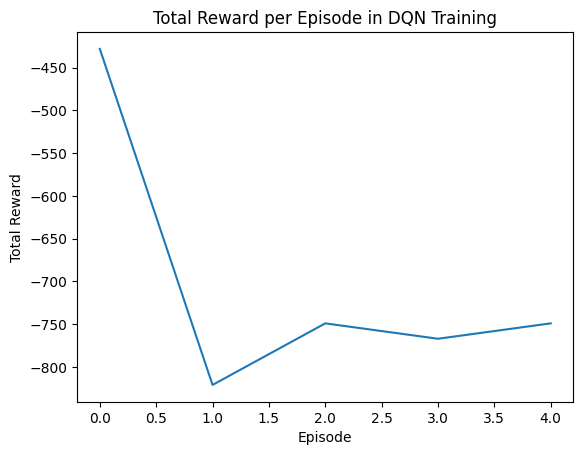

In [6]:
if __name__ == "__main__":
    episodes = 5  # Adjust as needed
    rewards_per_episode = train_dqn(episodes)

    # Plot the rewards per episode
    plt.plot(range(episodes), rewards_per_episode)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Total Reward per Episode in DQN Training')
    plt.show()